In [1]:
%%capture
# !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121
# !pip install pytorch_lightning==2.1
# !pip install pandas librosa opencv-python matplotlib  #cupy-cuda110 
# !pip install -U albumentations
# import timm 

In [2]:
import pandas as pd
import os
import torch
from IPython.display import display, Audio
import librosa
import math
import numpy as np
import scipy
from scipy import signal as sci_signal
import cv2
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
import pytorch_lightning as pl
import albumentations as albu
from torchvision.models import efficientnet
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pandas as pd
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from torch.utils.data import WeightedRandomSampler

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V
        

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype  for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

In [113]:
class CONFIG:
    
    # == GENERAL ==
    seed = 42                             # random seed
    device = 'cuda'                         # device to be used
    mix_precision = False                   # whether to use mixed-16 precision
    
    # == DATA ==
    preprocess = True
    preprocessed_data = '../../preprocessed_data/imgs_v0/'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/exp1_STAGE3_xca_5sec_selfmixup_sumixup_mixup_cutmix_3epochs_182bce_bce_augmenteddata_wdglr_bs8'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 1095                            # NFFT of Spec.
    win_len = 412                          # WIN_SIZE of Spec.
    hop_len = 100                         # overlap of Spec.
    min_freq = 40                           # min frequency
    max_freq = 15000                        # max frequency
    
    # == MODEL ==
    model = 'efficientnet_b0'               # model architecture
    
    # == DATASET ==
    batch_size = 32                         # batch size of each step
    n_workers = 4                           # number of workers
    
    # == AUG ==
    USE_HORIZFLIP = True
    USE_XYMASKING = True                    # whether use XYMasking

    # == TRAINING ==
    folds = 5                              # n fold
    epochs = 5                             # max epochs
    epochs_stage_1 = 5
    epochs_stage_2 = 10
    lr = 1e-4                               # learning rate
    weight_decay = 1e-4                     # weight decay of optimizer
    visualize = True                        # whether to visualize data and batch

In [5]:
df = pd.read_csv("2024_with_30sec_slices.csv")
df.head()

# Labels
label_list = sorted(df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

train_df = df[['primary_label', 'sliced_path','wav_path','secondary_labels','rating']].copy()  # Uses only audio, label and rating.

# Create Target
train_df['target'] = train_df.primary_label.map(label2id)

# Create Filepath
# train_df['filepath'] = CONFIG.data_dir_2024 + '/train_audio/' + train_df.filename

# Create Name
train_df['name'] = train_df.wav_path.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

In [6]:
import torchaudio
def preprocess_fn(filepath, input_audio = None):

    if(input_audio is not None):
        waveform = input_audio
    else:
    # LOAD .OGG
        waveform, sample_rate = torchaudio.load(filepath, normalize=True)
        # waveform = waveform[:5*sample_rate]

    # print(len(waveform.shape))
    # if(len(waveform.shape) < 2):
        # waveform
    
    transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
    spectrogram = transform(waveform)
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    spectrogram = db_transform(spectrogram)

    # print(spectrogram.shape)
    spec_data = normalize_melspec(spectrogram).squeeze(0) 
    # spec_data = spec_data.expand(3, -1, -1).permute(1, 2, 0).numpy()
    
    # print(spec_data.shape)
    # spec_data = albu.Resize(256, 256)(image=spec_data)
    # spec_data = albu.Normalize()(image=spec_data['image'])['image'].astype(np.float32)
    # spec = res['image'].astype(np.float32)
    # spec_data = spec_data.transpose(2, 0, 1)
    # print(spec_data['image'].shape)
    return spec_data

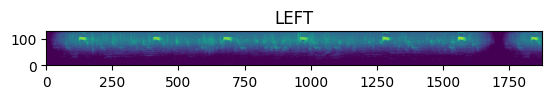

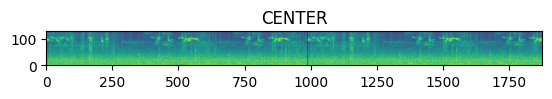

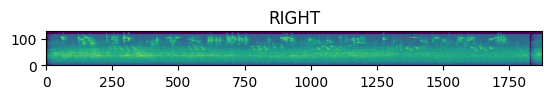

In [7]:
# Just testing

processed_spec_left = preprocess_fn(train_df['sliced_path'].values[0])
processed_spec_center = preprocess_fn(train_df['sliced_path'].values[1])
processed_spec_right = preprocess_fn(train_df['sliced_path'].values[2])

plt.figure()
plt.title('LEFT')
plt.imshow(processed_spec_left, origin='lower')
plt.show()

plt.figure()
plt.title('CENTER')
plt.imshow(processed_spec_center, origin='lower')
plt.show()

plt.figure()
plt.title("RIGHT")
plt.imshow(processed_spec_right, origin='lower')
plt.show()

In [8]:
processed_spec_center.shape, processed_spec_center.mean(), processed_spec_center.min()

(torch.Size([128, 1876]), tensor(0.5328), tensor(0.))

In [9]:
import torchaudio.transforms as T
import torchaudio
import numpy

In [10]:
import random
class BackgroundAugmentation(object):
    def __init__(self, min_scale, max_scale, back_df, mode = 'train'):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.backgrounds = back_df
        self.mode = mode

    def __call__(self, waveform):
        numero_aleatorio = random.randint(0, len(self.backgrounds)-1)
        noise_path = self.backgrounds.sliced_path.values[numero_aleatorio]
        noise, sample_rate = librosa.load(noise_path, sr = None)

        # Getting 5 seconds through a p.05 selfmixup
        rand_scale = random.uniform(0, 1)
        ridx = random.randint(0, 5)
        if(rand_scale > 0.5):
            wave = selfmixup(data=noise.reshape(-1, 5*32000), alpha=0.95)
            noise = wave[ridx:ridx+1, :][0]

        else:
            noise = noise[ridx*32000:(ridx+5)*32000]
            
        
        # noise = np.concatenate([noise]*3) #if training with 15sec
            
        rand_scale = random.uniform(self.min_scale, self.max_scale)
#         print(rand_scale)
        noisy_speech = (rand_scale * waveform + noise) / (1+rand_scale)
#         print(waveform.mean(), noisy_speech.mean())
        return noisy_speech

In [11]:
def selfmixup(data, alpha):
    
    data = torch.tensor(data)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    # shuffled_targets = targets[indices]
    #print(indices)
    lam = np.random.beta(alpha, alpha)
    # print(lam)
    #print(lam)
    new_data = data * lam + shuffled_data * (1 - lam)
    # new_targets = targets * lam + shuffled_targets * (1 - lam)
    return new_data.numpy()

In [12]:
# list_augs = os.listdir('../../preprocessed_data/5sec_unlabeleds_center/')
# list_augs = ['../../preprocessed_data/5sec_unlabeleds_center/' + w for w in list_augs]

# ex_df = pd.DataFrame({'wav_path': list_augs})
ex_df = pd.read_csv('2024_unlabelled_with_30sec_slices.csv')

In [13]:

backaud = BackgroundAugmentation(0.1,0.1, ex_df, mode = 'train')

In [14]:
train_df.head(2)

,primary_label,sliced_path,wav_path,secondary_labels,rating,target,name
0,asbfly,../../preprocessed_data/2024_30sec/data_2024_t...,../../data/2024/train_audio/asbfly/XC134896.ogg,[],5.0,0,..-XC134896
1,asbfly,../../preprocessed_data/2024_30sec/data_2024_t...,../../data/2024/train_audio/asbfly/XC164848.ogg,[],2.5,0,..-XC164848


In [15]:
ex = train_df['sliced_path'].values[3]
waveform, sample_rate = librosa.load(ex, sr = None)
print(len(waveform)/sample_rate, sample_rate)
waveform = backaud(waveform[:5*32000])
Audio(waveform, rate = sample_rate)

30.0 32000


In [16]:
ex_df_train, ex_df_val = train_test_split(ex_df, test_size = 0.2, random_state = 42)

In [17]:
y , sr = librosa.load(train_df.sliced_path[0], sr = None)
print(sr, y.shape)
wave = selfmixup(data=y.reshape(-1, 5*32000), alpha=0.95)

32000 (960000,)


In [18]:
import random
class SumMixUp(object):
    def __init__(self, df, labels, min_pct= 0.3, max_pct=1):
        self.df = df
        self.labels = labels
        self.min_pct = min_pct
        self.max_pct = max_pct

    def __call__(self, waveform, label):
        idx = random.randint(0, len(self.df)-1)
        noise_path = self.df.sliced_path.values[idx]
        random_wav, sample_rate = librosa.load(noise_path, sr = None)

        #dont need it here
        # # Getting 5 seconds through a p.05 selfmixup
        # rand_scale = random.uniform(0, 1)
        # ridx = random.randint(0, 5)
        # if(rand_scale > 0.5):
        #     wave = selfmixup(data=random_wav.reshape(-1, 5*32000), alpha=0.95)
        #     random_wav = wave[ridx:ridx+1, :][0]

        # else:
        #     random_wav = random_wav[ridx*32000:(ridx+5)*32000]

        
        random_label = self.labels[idx]

        rand1 = random.uniform(0, self.max_pct - self.min_pct) + self.min_pct
        rand2 = random.uniform(0, self.max_pct - self.min_pct) + self.min_pct


        ridx = random.randint(0, 5) # Works because of 6 * 5sec chunks
        waveform = rand1*waveform + rand2*random_wav[ridx*32000:(ridx+5)*32000]
        
        if rand1 >= 0.5:
            rand1 = 1
        else:
            rand1 = 1 - 2*(0.5 - rand1)

        if rand2 >= 0.5:
            rand2 = 0.9
        else:
            rand2 = 0.9*(1 - 2*(0.5 - rand2))

        # print(rand1, rand2)
        
        label = rand1*label + rand2*random_label

        # print(label)
        return waveform , np.clip(label, 0 ,1)

In [19]:
labels = np.eye(182)[train_df["target"].astype(int).values]

In [20]:
smu = SumMixUp(train_df, labels)

In [21]:
i = 2
y , sr = librosa.load(train_df.sliced_path[i], sr = None)
print(sr, y.shape)
wave, l = smu(y[:5*32000], labels[i])
Audio(wave, rate = sr)

32000 (960000,)


In [22]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        df,
        back_augmentation = None,
        use_sumixup = False,
        spec_augmentation=None,
        mode='train',
        n_sumixup =1,
        da_df=None,
    ):
        super().__init__()
        self.df = df
        self.back_augmentation = back_augmentation
        self.summixup = None
        self.spec_augmentation = spec_augmentation
        self.mode = mode
        self.labels = np.eye(self.df.target.nunique())[self.df["target"].astype(int).values]
        self.n_sumixup = n_sumixup
        if use_sumixup:
            print("Using SumMixUp")
            self.summixup = SumMixUp(self.df, self.labels)

        if self.back_augmentation is not None:
            print("Using random background noise of unlabelled soundscapes")

        self.da_df = da_df
        if self.da_df is not None:
            print('Using domain adaptation loader')
            
    def __len__(self):
        return len(self.df)
    
    # def __getitem__(self, index):
    def __getitem__(self, index):
        wav_path = self.df.sliced_path.values[index]
        # target
        target = self.labels[index]
        
        input_audio, sr = torchaudio.load(wav_path, normalize=True)
        input_audio = input_audio[0].numpy()

        rand_scale = random.uniform(0, 1)
        ridx = random.randint(0, 5)
        if(rand_scale > 0.2):
            wave = selfmixup(data=input_audio.reshape(-1, 5*32000), alpha=0.95)
            input_audio = wave[ridx:ridx+1, :][0]

        else:
            input_audio = input_audio[ridx*32000:(ridx+5)*32000]

        if self.summixup is not None:
            # print('using sumixup')
            for _ in range(self.n_sumixup):
                rand_scale = random.uniform(0, 1)
                if(rand_scale > 0.3):
                    input_audio, target = self.summixup(input_audio, target)
            
        # aug
        if self.back_augmentation is not None:
            # print('using backaug')
            # rand_scale = random.uniform(0, 1)
            # if(rand_scale > 0.3 and self.mode == 'train'):
            # input_audio_noised = self.back_augmentation(input_audio)
            if(self.mode == 'valid'):
                input_audio = self.back_augmentation(input_audio)
                
        input_spec = preprocess_fn('', input_audio = torch.tensor(input_audio).unsqueeze(0))
        
        if self.spec_augmentation is not None:
            input_spec = self.spec_augmentation(image=input_spec.numpy())['image']

        noised_spec = torch.zeros(2)
        if self.da_df is not None:
            numero_aleatorio = random.randint(0, len(self.da_df)-1)
            noise_path = self.da_df.sliced_path.values[numero_aleatorio]
            noise, sample_rate = librosa.load(noise_path, sr = None)
    
            # Getting 5 seconds through a p.05 selfmixup
            rand_scale = random.uniform(0, 1)
            ridx = random.randint(0, 5)
            if(rand_scale > 0.5):
                wave = selfmixup(data=noise.reshape(-1, 5*32000), alpha=0.95)
                noise = wave[ridx:ridx+1, :][0]
    
            else:
                noise = noise[ridx*32000:(ridx+5)*32000]
        # print(input_audio_noised.shape)
            noised_spec = preprocess_fn('', input_audio = torch.tensor(noise).unsqueeze(0))
        # if self.spec_augmentation is not None:
        #     noised_spec = self.spec_augmentation(image=noised_spec.numpy())['image']
            
        return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)

In [23]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
            albu.GaussNoise(var_limit=(0.01, 0.05), mean=0),
            albu.HorizontalFlip(0.5) if CONFIG.USE_XYMASKING else albu.NoOp(),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 5),
                num_masks_y=(1, 3),
                mask_x_length=(1, 20),
                mask_y_length=(1, 5),
            ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [24]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label,_ = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            # print(img.min().item())
            min_ = img.min().item()
            max_ = img.max().item()
            # print(min_, max_)
            # print(img_index[i], img)
            img = img.detach().numpy()
            # print(img.min(), img.max())
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        # ax.imshow(img, cmap='jet')
        ax.imshow(img)
        ax.set_title(f'ID: {img_index[i]}; Target: {label.argmax()}')
    
    plt.tight_layout()
    plt.show()

Using SumMixUp
Using random background noise of unlabelled soundscapes
Using domain adaptation loader


/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)


(128, 313)


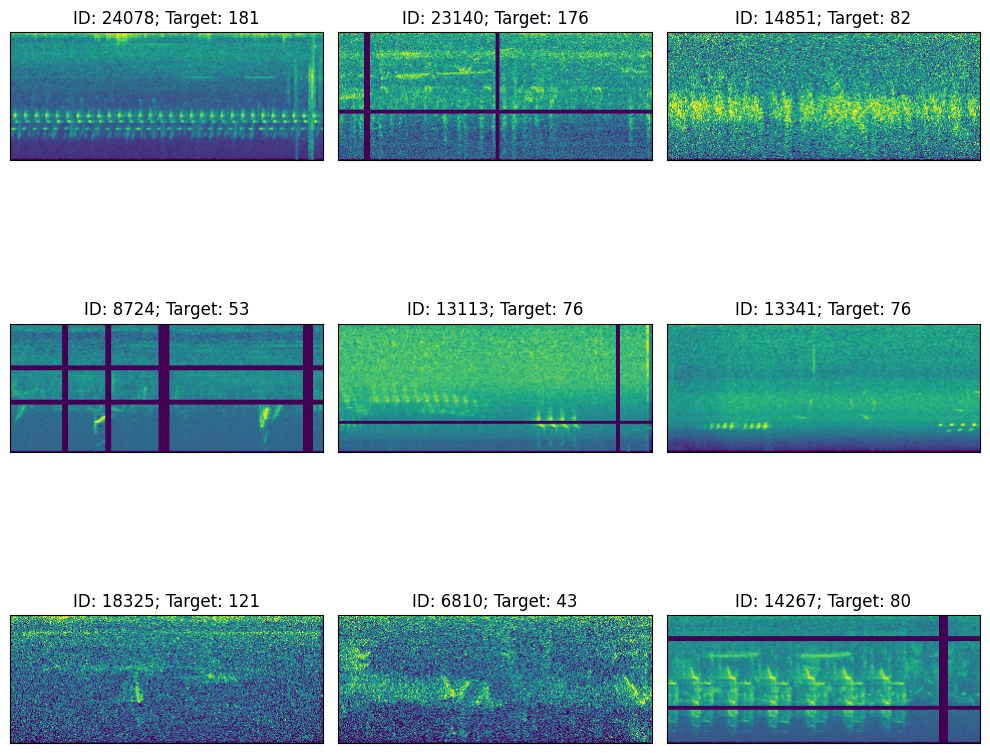

In [25]:
backaud = BackgroundAugmentation(0.1,0.1, ex_df, 'train')

dummy_dataset = BirdDataset( 
        train_df,
        back_augmentation = backaud,
        use_sumixup = True,
        spec_augmentation=get_transforms('train'),
        mode='train',
        da_df = ex_df)

test_input, test_target, _ = dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)


In [26]:
del dummy_dataset
gc.collect()

19529

In [27]:
# Getting original splits
kf = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y=train_df['target'])):
    for idx in val_idx:
        train_df.iloc[idx, train_df.columns.get_loc('fold') ] = fold

In [28]:
# # Reading additional data
aug_df = pd.read_csv("past_competition_30sec_slices.csv")
aug_df.head(2)

,wav_path,primary_label,secondary_labels,rating,filename,mapped,sliced_path
0,../../data/2021/train_short_audio/acafly/XC109...,acafly,['amegfi'],2.5,acafly_XC109605.ogg,132,../../preprocessed_data/2021_2022_2023_30sec/d...
1,../../data/2021/train_short_audio/acafly/XC112...,acafly,[],3.0,acafly_XC11209.ogg,132,../../preprocessed_data/2021_2022_2023_30sec/d...


In [29]:
aug_df['maped'] = aug_df.primary_label.map(aug_df.primary_label.value_counts())
aug_df = aug_df[(aug_df.maped > 5) & (aug_df.maped < 100)]
aug_df.primary_label.nunique()

401

In [30]:
# # Labels
init_new_label = 182
for p in aug_df.primary_label.unique():
    if p not in label2id.keys():
        label2id[p] = init_new_label
        init_new_label+= 1
        
id2label = dict(zip(label_id_list, label_list))

aug_df = aug_df[['primary_label', 'sliced_path','secondary_labels','rating']].copy()  # Uses only audio, label and rating.

# # Create Target
aug_df['target'] = aug_df.primary_label.map(label2id)

In [31]:
aug_df.target.value_counts()

target
255    99
381    99
209    99
210    99
265    99
       ..
485     6
487     6
522     6
523     6
305     6
Name: count, Length: 401, dtype: int64

In [32]:
# Getting augmented splits
kf = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
aug_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(aug_df, y=aug_df['target'])):
    for idx in val_idx:
        aug_df.iloc[idx, aug_df.columns.get_loc('fold') ] = fold

In [33]:
train_df = pd.concat([train_df, aug_df]).reset_index(drop=True)
train_df.fold.value_counts()

fold
0    8330
1    8329
3    8329
2    8329
4    8329
Name: count, dtype: int64

In [34]:
for fold in train_df.fold.unique():
    print(train_df[train_df['fold']== fold].primary_label.nunique())

579
579
579
579
579


In [35]:
full_label_list = sorted(train_df['primary_label'].unique())
len(full_label_list)

579

In [69]:
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim


'''
MetaStyleSpeech style encoder https://arxiv.org/pdf/2106.03153.pdf

Adapted from: https://github.com/keonlee9420/StyleSpeech

'''

import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F


class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class FCBlock(nn.Module):
    """ Fully Connected Block """

    def __init__(self, in_features, out_features, activation=None, bias=False, dropout=None, spectral_norm=False):
        super(FCBlock, self).__init__()
        self.fc_layer = nn.Sequential()
        self.fc_layer.add_module(
            "fc_layer",
            LinearNorm(
                in_features,
                out_features,
                bias,
                spectral_norm,
            ),
        )
        if activation is not None:
            self.fc_layer.add_module("activ", activation)
        self.dropout = dropout

    def forward(self, x):
        x = self.fc_layer(x)
        if self.dropout is not None:
            x = F.dropout(x, self.dropout, self.training)
        return x


class LinearNorm(nn.Module):
    """ LinearNorm Projection """

    def __init__(self, in_features, out_features, bias=False, spectral_norm=False):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)

        nn.init.xavier_uniform_(self.linear.weight)
        if bias:
            nn.init.constant_(self.linear.bias, 0.0)
        if spectral_norm:
            self.linear = nn.utils.spectral_norm(self.linear)

    def forward(self, x):
        x = self.linear(x)
        return x


class Conv1DBlock(nn.Module):
    """ 1D Convolutional Block """

    def __init__(self, in_channels, out_channels, kernel_size, activation=None, dropout=None, spectral_norm=False):
        super(Conv1DBlock, self).__init__()

        self.conv_layer = nn.Sequential()
        self.conv_layer.add_module(
            "conv_layer",
            ConvNorm(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=int((kernel_size - 1) / 2),
                dilation=1,
                w_init_gain="tanh",
                spectral_norm=spectral_norm,
            ),
        )
        if activation is not None:
            self.conv_layer.add_module("activ", activation)
        self.dropout = dropout

    def forward(self, x, mask=None):
        x = x.contiguous().transpose(1, 2)
        x = self.conv_layer(x)

        if self.dropout is not None:
            x = F.dropout(x, self.dropout, self.training)

        x = x.contiguous().transpose(1, 2)
        if mask is not None:
            x = x.masked_fill(mask.unsqueeze(-1), 0)

        return x


class ConvNorm(nn.Module):
    """ 1D Convolution """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=1,
        stride=1,
        padding=None,
        dilation=1,
        bias=True,
        w_init_gain="linear",
        spectral_norm=False,
    ):
        super(ConvNorm, self).__init__()

        if padding is None:
            assert kernel_size % 2 == 1
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
        )
        if spectral_norm:
            self.conv = nn.utils.spectral_norm(self.conv)

    def forward(self, signal):
        conv_signal = self.conv(signal)

        return conv_signal

class MultiHeadAttention(nn.Module):
    """ Multi-Head Attention """

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1, layer_norm=False, spectral_norm=False):
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = LinearNorm(d_model, n_head * d_k, spectral_norm=spectral_norm)
        self.w_ks = LinearNorm(d_model, n_head * d_k, spectral_norm=spectral_norm)
        self.w_vs = LinearNorm(d_model, n_head * d_v, spectral_norm=spectral_norm)

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model) if layer_norm else None

        self.fc = LinearNorm(n_head * d_v, d_model, spectral_norm=spectral_norm)

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k)  # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k)  # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v)  # (n*b) x lv x dv
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)  # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v)
        output = (
            output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1)
        )  # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = output + residual
        if self.layer_norm is not None:
            output = self.layer_norm(output)

        return output, attn


class ScaledDotProductAttention(nn.Module):
    """ Scaled Dot-Product Attention """

    def __init__(self, temperature):
        super(ScaledDotProductAttention, self).__init__()
        self.temperature = temperature
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -1e9)

        attn = self.softmax(attn)
        output = torch.bmm(attn, v)

        return output, attn


class PositionwiseFeedForward(nn.Module):
    """ A two-feed-forward-layer """

    def __init__(self, d_in, d_hid, kernel_size, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()

        # Use Conv1D
        # position-wise
        self.w_1 = nn.Conv1d(
            d_in,
            d_hid,
            kernel_size=kernel_size[0],
            padding=(kernel_size[0] - 1) // 2,
        )
        # position-wise
        self.w_2 = nn.Conv1d(
            d_hid,
            d_in,
            kernel_size=kernel_size[1],
            padding=(kernel_size[1] - 1) // 2,
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = output + residual

        return output
    
def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    	
    #print(f'lengths = {lengths}')
    #print(f'max_len = {max_len}')
    
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool() # (B, max_len)
    return mask


class XCA(nn.Module):
    """ Cross-Covariance Attention (XCA) operation where the channels are updated using a weighted
     sum. The weights are obtained from the (softmax normalized) Cross-covariance
    matrix (Q^T K \\in d_h \\times d_h)
    """

    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.2, proj_drop=0.2):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 3, 1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'temperature'}

class XCAMetaBird(nn.Module):
    """ Mel-Style Encoder """

    def __init__(self, num_mel, embedding_dim, num_classes, n_spectral = 2, n_temporal = 2, n_mha = 2, mha_heads = 1, max_seq_len = 400):
        super(XCAMetaBird, self).__init__()
        self.num_classes = num_classes
        # n_position = model_config["max_seq_len"] + 1
        n_mel_channels = num_mel
        d_melencoder = embedding_dim
        n_spectral_layer = n_spectral
        n_temporal_layer = n_temporal
        n_slf_attn_layer = n_mha
        n_slf_attn_head = mha_heads
        d_k = d_v = (
            embedding_dim
            // mha_heads
        )
        kernel_size = 3
        dropout = 0.2

        self.max_seq_len = max_seq_len # This is our default, but it is interesting to be adaptive

        self.fc_1 = FCBlock(n_mel_channels, d_melencoder)

        self.spectral_stack = nn.ModuleList(
            [
                FCBlock(
                    d_melencoder, d_melencoder, activation=Mish()
                )
                for _ in range(n_spectral_layer)
            ]
        )

        
        self.temporal_stack = nn.ModuleList(
            [
                nn.Sequential(
                    Conv1DBlock(
                        d_melencoder, 2 * d_melencoder, kernel_size, activation=Mish(), dropout=dropout
                    ),
                    # nn.AvgPool1d(3, stride=1, padding=1),
                    nn.GLU(),
                )
                for _ in range(n_temporal_layer)
            ]
        )

        self.slf_attn_stack = nn.ModuleList(
            [
                XCA(
                    d_melencoder, n_slf_attn_head
                )
                for _ in range(n_slf_attn_layer)
            ]
        )
        

        self.fc_2 = FCBlock(d_melencoder, d_melencoder)

        self.classifier_layer = nn.Linear(embedding_dim, self.num_classes)
        self.attn = nn.Linear(embedding_dim, 1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, mel):
        # mel -> (BS, MEL_DIM, L)
        # print(f'mel shape = {mel.shape}')

        # Tranposing mel input to be (L, MEL_DIM)
        mel = mel.permute(0,2,1) # -> (BS, L, MEL_DIM)

        # Pre-net per frame
        enc_output = self.fc_1(mel) # -> (BS, L, EMB_SIZE)
        # print(f'enc_output shape = {enc_output.shape}')

        # Spectral Processing per frame
        for _, layer in enumerate(self.spectral_stack):
            enc_output = layer(enc_output) # -> (BS, L, EMB_SIZE)
        # print(f'after spectral process shape = {enc_output.shape}')


        # Temporal Processing (only per frame to get temporal patterns)
        for _, layer in enumerate(self.temporal_stack):
            residual = enc_output
            enc_output = layer(enc_output)
            enc_output = residual + enc_output # -> (BS, L, EMB_SIZE)

        # print(f'after temporal process shape = {enc_output.shape}')
        
        # Multi-head self-attention per frame
        for _, layer in enumerate(self.slf_attn_stack):
            residual = enc_output
            enc_output = layer(
                enc_output
            )
            enc_output = residual + enc_output # -> (BS, L, EMB_SIZE)
        # print(f'after mha process shape = {enc_output.shape}')
        
        # Post-net for frames and frequency
        enc_output = self.fc_2(self.activation(enc_output)) # -> (BS, L, EMB_SIZE)


        attn_weights = F.softmax(self.attn(enc_output), dim=1) # -> (BS, 2, 1)
        # print(attn_weights.shape)
        enc_output = torch.sum(enc_output * attn_weights, dim=1) # -> (BS, EMB_SIZE)
        
        pred = self.classifier_layer(self.dropout(enc_output)) # -> (BS, NUM_CLASSES)

        return pred

    def forward_feats(self, mel):
        # mel -> (BS, MEL_DIM, L)
        # print(f'mel shape = {mel.shape}')

        # Tranposing mel input to be (L, MEL_DIM)
        mel = mel.permute(0,2,1) # -> (BS, L, MEL_DIM)

        # Pre-net per frame
        enc_output = self.fc_1(mel) # -> (BS, L, EMB_SIZE)
        # print(f'enc_output shape = {enc_output.shape}')

        # Spectral Processing per frame
        for _, layer in enumerate(self.spectral_stack):
            enc_output = layer(enc_output) # -> (BS, L, EMB_SIZE)
        # print(f'after spectral process shape = {enc_output.shape}')


        # Temporal Processing (only per frame to get temporal patterns)
        for _, layer in enumerate(self.temporal_stack):
            residual = enc_output
            enc_output = layer(enc_output)
            enc_output = residual + enc_output # -> (BS, L, EMB_SIZE)

        # print(f'after temporal process shape = {enc_output.shape}')
        
        # Multi-head self-attention per frame
        for _, layer in enumerate(self.slf_attn_stack):
            residual = enc_output
            enc_output = layer(
                enc_output
            )
            enc_output = residual + enc_output # -> (BS, L, EMB_SIZE)
        # print(f'after mha process shape = {enc_output.shape}')
        
        # Post-net for frames and frequency
        enc_output = self.fc_2(self.activation(enc_output)) # -> (BS, L, EMB_SIZE)


        attn_weights = F.softmax(self.attn(enc_output), dim=1) # -> (BS, 2, 1)
        # print(attn_weights.shape)
        enc_output = torch.sum(enc_output * attn_weights, dim=1) # -> (BS, EMB_SIZE)
        
        # pred = self.classifier_layer(self.dropout(enc_output)) # -> (BS, NUM_CLASSES)

        return enc_output

In [70]:
class MyModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.backbone = XCAMetaBird(128,128,734)
        # cpt = torch.load('./pre_trained_weights/xca_128emb_pastcompetition_mixup_cutmix/best_model_220968_61.pth', map_location='cpu')
        # self.backbone.load_state_dict(cpt)

        self.backbone.classifier_layer = nn.Linear(128, 579)
        # self.classifier_layer = nn.Linear(734,182)
        # print(self.backbone)
    def forward(self, mel):
        return self.backbone(mel)
    def forward_feats(self, mel):
        return self.backbone.forward_feats(mel)

In [71]:
# # cpt = torch.load('./pre_trained_weights/xca_128emb_pastcompetition_mixup_cutmix/best_model_220968_61.pth')
# # cpt
# from torchmetrics.classification import MultilabelRankingLoss
# from torchmetrics.functional.classification import multilabel_ranking_loss

In [72]:
n = MyModel()

x = torch.rand((2,128,313))
y = torch.randint(low=0, high=335, size=(1,1))[0]

pred = n(x)
pred.shape

torch.Size([2, 579])

In [73]:
pred = n.forward_feats(x)
pred.shape

torch.Size([2, 128])

In [74]:
# pred.squeeze(2).squeeze(2).shape

In [75]:
# n.backbone

In [76]:
del n 
gc.collect()

4055

In [77]:
# !pip install torchmetrics

In [78]:
# from torchmetrics.classification import MultilabelRankingLoss

In [137]:
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler
from augment import Mixup, Cutmix
from lr_scheduler import CosineAnnealingWarmupRestarts
from loss import BCEFocalLoss
from torch.autograd import grad

def gradient_penalty(critic, h_s, h_t):
    # based on: https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py#L116
    alpha = torch.rand(h_s.size(0), 1).to(h_s.device)
    differences = h_t - h_s
    interpolates = h_s + (alpha * differences)
    interpolates = torch.stack([interpolates, h_s, h_t]).requires_grad_()

    preds = critic(interpolates)
    gradients = grad(preds, interpolates,
                     grad_outputs=torch.ones_like(preds),
                     retain_graph=True, create_graph=True)[0]
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1)**2).mean()
    return gradient_penalty


def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

class BirdModel(pl.LightningModule):
    
    def __init__(self,steps_per_epoch):
        super().__init__()
        
        # == backbone ==
        # self.backbone = EffNet(CONFIG.model, n_classes=len(full_label_list))

        self.critic = nn.Sequential(
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Linear(32, 1)
                ).to(self.device)

        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=1e-4)
        
        # self.backbone = MetaStyleEncoder(128,128,182)
        self.backbone = MyModel()
        self.steps_per_epoch = steps_per_epoch
        # == loss function ==
        self.loss_fn = BCEFocalLoss()
        self.loss_fn_focal = BCEFocalLoss()

        self.loss_da = nn.CrossEntropyLoss()
        # self.loss_da = nn.MSELoss()

        self.mixup = Mixup(mix_beta=1)
        self.cutmix = Cutmix(1)
        
        # == record ==
        self.validation_step_outputs = []
        
        self.automatic_optimization = False
        
    def forward(self, images):
        return self.backbone(images)

    def forward_da(self,images):
        return self.backbone.forward_da(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )

        # model_optimizer = Adan(self.parameters(), lr=CONFIG.lr, betas=(0.02, 0.08, 0.01), weight_decay=1e-2)
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )

        # lr_scheduler = CosineAnnealingWarmupRestarts(
        #     model_optimizer,
        #     first_cycle_steps= CONFIG.epochs*2,
        #     cycle_mult=CONFIG.epochs,
        #     max_lr= CONFIG.lr,
        #     min_lr=1e-6,
        #     warmup_steps=0,
        #     gamma=1,
        #     last_epoch=-1
        # )
                
        # lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #     optimizer=model_optimizer, epochs=CONFIG.epochs,
        #     pct_start=0.0, steps_per_epoch=self.steps_per_epoch,
        #     max_lr=CONFIG.lr, div_factor=25, final_div_factor=4.0e-01
        # )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        opt = self.optimizers()

        
        # == obtain input and target ==
        image, target, da_image = batch
        image = image.to(self.device)
        target = target.to(self.device)
        da_image = da_image.to(self.device)

        # old
        # bs = image.shape[0]
        # da_input = torch.cat([image, da_image], dim = 0).to(self.device)
        # da_target = torch.cat([torch.zeros(bs), torch.ones(bs)], dim = 0).long().to(self.device)
        # da_y_pred = self.forward_da(da_input)

        set_requires_grad(self.backbone, requires_grad=False)
        set_requires_grad(self.critic, requires_grad=True)
        
        # WDGRL CRITIC STEP:
        with torch.no_grad():
            h_s = self.backbone.forward_feats(image)
            h_t = self.backbone.forward_feats(da_image)
        wd_loss = 0
        for _ in range(10): #10 steps of critic optimization
            gp = gradient_penalty(self.critic, h_s, h_t)

            critic_s = self.critic(h_s)
            critic_t = self.critic(h_t)
            
            wasserstein_distance = critic_s.mean() - critic_t.mean()
            critic_cost = -wasserstein_distance + 10*gp

            self.critic_optim.zero_grad()
            critic_cost.backward()
            self.critic_optim.step()

            wd_loss += critic_cost.item()
        wd_loss = wd_loss/10

        set_requires_grad(self.backbone, requires_grad=True)
        set_requires_grad(self.critic, requires_grad=False)
        # Classifier step
        tr_loss = 0
        tr_focal_loss = 0
        for _ in range(1):
            # == pred ==
            h_s = self.backbone.forward_feats(image)
            h_t = self.backbone.forward_feats(da_image)
            
            y_pred = self(image)
            
            # == compute loss ==
            tr_loss = self.loss_fn(y_pred, target)
            # train_loss_focal =  self.loss_fn_focal(y_pred[:, :182], target[:, :182])
    

            wasserstein_distance = self.critic(h_s).mean() - self.critic(h_t).mean()


            lambda_ = 0.0001
            loss = tr_loss + lambda_*wasserstein_distance

            opt.zero_grad()
            self.manual_backward(loss)

            # clip gradients
            # self.clip_gradients(opt, gradient_clip_val=0.5, gradient_clip_algorithm="norm")

            opt.step()
            
            # bottleneck_da = self.forward_da(da_).detach() # Detaching to act like a groundtruth (in our case the groundtruth is the clean representation)
            tr_loss += tr_loss.item()
            # tr_focal_loss += train_loss_focal.item()
        
            # lambda_da = get_grl_lambda((self.current_epoch)/(CONFIG.epochs))
            # lambda_da = 1
            # loss_da = self.loss_da(da_y_pred, da_target)
            # loss_da = torch.clamp(loss_da, max=1)
        # train_loss = train_loss 
        tr_loss = tr_loss
        # == record ==
        self.log('tr', tr_loss, True)
        # self.log('tr_f', tr_focal_loss, True)
        self.log('wd', wd_loss, True)
        # self.log('wd_c',lambda_*wasserstein_distance, True )
        # self.log('l_da', lambda_da, True)
        # return loss_da
        # return train_loss + lambda_da*loss_da
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target,_ = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach().float()
        
        # target to one-hot
#         target_val = torch.nn.functional.one_hot(target_val, len(label_list)).float()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val.to("cuda"), target_val.to("cuda"))
        
        
        target_val = np.ceil(target_val)
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=full_label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=full_label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

In [138]:
bird_model = BirdModel(steps_per_epoch = 999)

In [139]:
# bird_model.lr_schedulers[0]

In [140]:
bird_model.current_epoch

0

In [141]:
bird_model.global_step

0

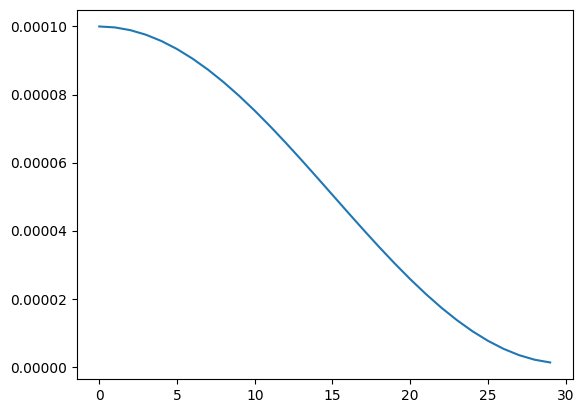

In [142]:
model_optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, MyModel().parameters()),
    lr=CONFIG.lr,
    weight_decay=CONFIG.weight_decay
)

# model_optimizer = Adan(self.parameters(), lr=CONFIG.lr, betas=(0.02, 0.08, 0.01), weight_decay=1e-2)

# == define learning rate scheduler ==
lr_scheduler = CosineAnnealingWarmupRestarts(
    model_optimizer,
    first_cycle_steps=30,
    cycle_mult=30,
    max_lr= CONFIG.lr,
    min_lr=1e-6,
    warmup_steps=0,
    gamma=1,
    last_epoch=-1
)

lrs = []
for i in range(30):
    lrs.append(lr_scheduler.get_lr())
    lr_scheduler.step()

plt.plot(lrs)

In [143]:
def predict(data_loader, model):
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y,_ = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
#     gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

def predict_noised(val_df, model):
    backaud_valid = BackgroundAugmentation(0.1,0.1, ex_df_val, mode = 'eval')
    val_ds = BirdDataset(val_df, backaud_valid, False, get_transforms('valid'), 'valid')
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    mixup = Mixup(mix_beta=1)
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(val_dl):
        with torch.no_grad():
            x, y,_ = batch
            x, y = mixup(x, y)
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
#     gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [144]:
def set_init_dict(model_dict, checkpoint_state, c):
    # Partial initialization: if there is a mismatch with new and old layer, it is skipped.
    for k, v in checkpoint_state.items():
        if k not in model_dict:
            print(" | > Layer missing in the model definition: {}".format(k))
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in checkpoint_state.items() if k in model_dict}
    # 2. filter out different size layers
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if v.numel() == model_dict[k].numel()}
    # 3. skip reinit layers
    # if c.has("reinit_layers") and c.reinit_layers is not None:
    #     for reinit_layer_name in c.reinit_layers:
    #         pretrained_dict = {k: v for k, v in pretrained_dict.items() if reinit_layer_name not in k}
    # 4. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    print(" | > {} / {} layers are restored.".format(len(pretrained_dict), len(model_dict)))
    return model_dict

def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df[f'fold'] != fold_id].copy()
    valid_df = total_df[total_df[f'fold'] == fold_id].copy()

    # train_df = train_df[(train_df['rating'] >= 3)|(train_df['volumetry'] < 20)]
    print(f'There are {train_df.primary_label.nunique()} targets')

    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')

    # == create a sampler that samples inversely of its counts ==
    y_train = train_df['target']
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
    
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    
    
    backaud = BackgroundAugmentation(0.1,0.3, ex_df_train)
    # backaud = None
#     backaud_valid = None
    backaud_valid = BackgroundAugmentation(0.1,0.1, ex_df_val)
    
    train_ds = BirdDataset(train_df, None, True, get_transforms('train'), 'train', 1, ex_df)
    # train_ds = BirdDataset(train_df, None, False, get_transforms('train'), 'train', 1, ex_df)
    # train_ds = BirdDataset(train_df, backaud, False, None, 'train')
    # val_ds = BirdDataset(valid_df, None, False, get_transforms('valid'), 'valid')
    # train_ds = BirdDataset(train_df, None, False, None, 'train')
    val_ds = BirdDataset(valid_df, None, False, None, 'valid')
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CONFIG.batch_size,
        shuffle=False, # If using sampler must be False
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True,
        sampler = sampler
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel(steps_per_epoch = len(train_dl))
    # bird_model = BirdModel()

    # Uncomment if fine tuning
    import re
    def modify_key(key):
        return re.sub(r'^[^.]+\.', '', key)
    cpt = torch.load(f'../chpks/exp1_STAGE2_xca_5sec_selfmixup_sumixup_mixup_cutmix_5epochs_182bce_bce_augmenteddata_surrogateloss_bs16/fold_{fold_id}.ckpt', map_location=torch.device('cpu'))['state_dict']
    
    modified_checkpoint = {modify_key(k): v for k, v in cpt.items()}

    print('loading pre trained')
    # cpt = torch.load(f'../chpks/exp1_effnet_5sec_effnet_selfmixup_sumixup_mixup_cutmix_10epochs_surrogateloss_focal_bce/fold_{fold_id}.ckpt', map_location=torch.device('cpu'))['state_dict']
    # bird_model.load_state_dict(cpt)
    # bird_model_dict = bird_model.state_dict()
    # bird_model_dict = set_init_dict(bird_model_dict, cpt, None)
    bird_model.backbone.load_state_dict(modified_checkpoint)
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=CONFIG.checkpoint_dir,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=CONFIG.epochs,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=False, # Default is True, but it doest not work with metastylespeech
        precision='16-mixed' if CONFIG.mix_precision else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=full_label_list)
    pred_df = pred_df[label_list]
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=full_label_list)
    gt_df = gt_df[label_list]
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df.apply(np.ceil), pred_df, row_id_column_name='id')
    
    preds_noised, gts_noised = predict_noised(valid_df, bird_model)
    
    # = create dataframe =
    pred_df_noised = pd.DataFrame(preds_noised, columns=full_label_list)
    pred_df_noised = pred_df_noised[label_list]
    pred_df_noised['id'] = np.arange(len(pred_df_noised))
    gt_df_noised = pd.DataFrame(gts_noised, columns=full_label_list)
    gt_df_noised = gt_df_noised[label_list]
    gt_df_noised['id'] = np.arange(len(gt_df_noised))
    
    # = compute score =
    val_score_noised = score(gt_df_noised.apply(np.ceil), pred_df_noised, row_id_column_name='id')

    pd.DataFrame({f'val_noised': [val_score_noised], f'val_clean': [val_score]}).to_csv(f'{CONFIG.checkpoint_dir}/score_fold_{fold_id}.csv', index = False)
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in full_label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(full_label_list)*2)).astype(np.float32), columns=full_label_list+pred_cols)], axis=1)
    valid_df[full_label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{CONFIG.checkpoint_dir}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score, val_score_noised

In [145]:
torch.cat([torch.zeros(16), torch.ones(16)], dim = 0).shape

torch.Size([32])

In [146]:
# training
torch.set_float32_matmul_precision('high')

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

# record
fold_val_score_list = list()
fold_val_score_noised_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in full_label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=full_label_list+pred_cols)], axis=1)

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df[f'fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score, val_score_noised = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, full_label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)
    fold_val_score_noised_list.append(val_score_noised)
    print(f'Fold {f} Val Score: {fold_val_score_list[f]:.5f} Val Score Noised: {fold_val_score_noised_list[f]:.5f}')
    
for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f} Val Score Noised: {fold_val_score_noised_list[idx]:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)

==== Running training for fold 0 ====
There are 579 targets
Train Samples: 33316
Valid Samples: 8330
Using SumMixUp
Using domain adaptation loader
loading pre trained


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/exp1_STAGE3_xca_5sec_selfmixup_sumixup_mixup_cutmix_3epochs_182bce_bce_augmenteddata_wdglr_bs8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Sanity Checking: |                                                                                | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)


Training: |                                                                                       | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)


Epoch 0:   0%|                                                                                 | 0/1042 [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)


Epoch 0:  50%|██████████████████▌                  | 521/1042 [05:00<05:00,  1.73it/s, v_num=172, tr=0.00324, wd=-0.861]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|████████████████████| 1042/1042 [11:57<00:00,  1.45it/s, v_num=172, tr=0.00277, wd=2.590, val_score=0.881]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1:  50%|██████████          | 521/1042 [05:38<05:38,  1.54it/s, v_num=172, tr=0.00315, wd=-0.549, val_score=0.884]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████| 1042/1042 [11:57<00:00,  1.45it/s, v_num=172, tr=0.00333, wd=3.430, val_score=0.894]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2:  50%|██████████        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|████████████████████| 1042/1042 [10:10<00:00,  1.71it/s, v_num=172, tr=0.00297, wd=2.950, val_score=0.918]




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Using random background noise of unlabelled soundscapes




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Epoch 0:   0%|                                                                               | 0/1042 [2:10:23<?, ?it/s]
Fold 0 Val Score: 0.92258 Val Score Noised: 0.62768
==== Running training for fold 1 ====
There are 579 targets
Train Samples: 33317
Valid Samples: 8329
Using SumMixUp
Using domain adaptation loader
loading pre trained


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/exp1_STAGE3_xca_5sec_selfmixup_sumixup_mixup_cutmix_3epochs_182bce_bce_augmenteddata_wdglr_bs8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Sanity Checking: |                                                                                | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:   0%|                                                                                 | 0/1042 [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:  50%|██████████████████▌                  | 521/1042 [04:39<04:39,  1.87it/s, v_num=174, tr=0.00331, wd=-0.189]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|████████████████████| 1042/1042 [11:09<00:00,  1.56it/s, v_num=174, tr=0.00382, wd=3.220, val_score=0.871]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1:  50%|██████████          | 521/1042 [04:53<04:53,  1.78it/s, v_num=174, tr=0.00346, wd=-0.252, val_score=0.882]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████| 1042/1042 [11:48<00:00,  1.47it/s, v_num=174, tr=0.00312, wd=2.690, val_score=0.891]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2:  50%|██████████        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████| 1042/1042 [11:02<00:00,  1.57it/s, v_num=174, tr=0.0028, wd=3.520, val_score=0.915]




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Using random background noise of unlabelled soundscapes




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Fold 1 Val Score: 0.91882 Val Score Noised: 0.64534
==== Running training for fold 2 ====
There are 579 targets
Train Samples: 33317
Valid Samples: 8329
Using SumMixUp
Using domain adaptation loader
loading pre trained


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/exp1_STAGE3_xca_5sec_selfmixup_sumixup_mixup_cutmix_3epochs_182bce_bce_augmenteddata_wdglr_bs8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Sanity Checking: |                                                                                | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:   0%|                                                                                 | 0/1042 [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:  50%|██████████████████▌                  | 521/1042 [04:32<04:32,  1.91it/s, v_num=176, tr=0.00336, wd=-0.629]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|████████████████████| 1042/1042 [09:36<00:00,  1.81it/s, v_num=176, tr=0.00306, wd=3.330, val_score=0.881]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1:  50%|██████████          | 521/1042 [03:44<03:44,  2.32it/s, v_num=176, tr=0.00309, wd=-0.371, val_score=0.898]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████| 1042/1042 [08:55<00:00,  1.95it/s, v_num=176, tr=0.0031, wd=2.970, val_score=0.904]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2:  50%|██████████        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|████████████████████| 1042/1042 [09:50<00:00,  1.77it/s, v_num=176, tr=0.00262, wd=3.710, val_score=0.924]




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Using random background noise of unlabelled soundscapes




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Fold 2 Val Score: 0.92845 Val Score Noised: 0.65051
==== Running training for fold 3 ====
There are 579 targets
Train Samples: 33317
Valid Samples: 8329
Using SumMixUp
Using domain adaptation loader
loading pre trained


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/exp1_STAGE3_xca_5sec_selfmixup_sumixup_mixup_cutmix_3epochs_182bce_bce_augmenteddata_wdglr_bs8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Sanity Checking: |                                                                                | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:   0%|                                                                                 | 0/1042 [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:  50%|██████████████████▌                  | 521/1042 [04:19<04:19,  2.00it/s, v_num=178, tr=0.00292, wd=-0.964]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|████████████████████| 1042/1042 [09:58<00:00,  1.74it/s, v_num=178, tr=0.00336, wd=1.950, val_score=0.871]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1:  50%|██████████          | 521/1042 [04:09<04:09,  2.09it/s, v_num=178, tr=0.00306, wd=-0.502, val_score=0.888]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████| 1042/1042 [10:19<00:00,  1.68it/s, v_num=178, tr=0.00232, wd=3.190, val_score=0.893]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2:  50%|██████████        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|████████████████████| 1042/1042 [10:31<00:00,  1.65it/s, v_num=178, tr=0.00337, wd=3.510, val_score=0.917]




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Using random background noise of unlabelled soundscapes




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Fold 3 Val Score: 0.91802 Val Score Noised: 0.64202
==== Running training for fold 4 ====
There are 579 targets
Train Samples: 33317
Valid Samples: 8329
Using SumMixUp
Using domain adaptation loader
loading pre trained


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/exp1_STAGE3_xca_5sec_selfmixup_sumixup_mixup_cutmix_3epochs_182bce_bce_augmenteddata_wdglr_bs8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:314: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.


Sanity Checking: |                                                                                | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:   0%|                                                                                 | 0/1042 [00:00<?, ?it/s]

/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  retur

Epoch 0:  50%|███████████████████▌                   | 521/1042 [04:56<04:56,  1.76it/s, v_num=180, tr=0.0032, wd=-0.73]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|████████████████████| 1042/1042 [10:57<00:00,  1.58it/s, v_num=180, tr=0.00339, wd=2.780, val_score=0.874]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1:  50%|██████████          | 521/1042 [04:53<04:53,  1.78it/s, v_num=180, tr=0.00312, wd=-0.474, val_score=0.889]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████| 1042/1042 [11:10<00:00,  1.55it/s, v_num=180, tr=0.0029, wd=3.220, val_score=0.894]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2:  50%|██████████▌       

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|████████████████████| 1042/1042 [11:33<00:00,  1.50it/s, v_num=180, tr=0.00397, wd=3.480, val_score=0.919]




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Using random background noise of unlabelled soundscapes




  0%|                                                                                           | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32)), torch.tensor(noised_spec, dtype=torch.float32)
/tmp/ipykernel_106235/786911631.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Fold 4 Val Score: 0.91977 Val Score Noised: 0.64325
Fold 0 Val Score: 0.92258 Val Score Noised: 0.62768
Fold 1 Val Score: 0.91882 Val Score Noised: 0.64534
Fold 2 Val Score: 0.92845 Val Score Noised: 0.65051
Fold 3 Val Score: 0.91802 Val Score Noised: 0.64202
Fold 4 Val Score: 0.91977 Val Score Noised: 0.64325


In [ ]:
## replicating metrics of actual model but with the same pipeline as previous
PATH_TO = CONFIG.checkpoint_dir

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

for f in range(CONFIG.folds):
    eval_df = train_df[train_df[f'fold'] == f].copy()

    val_ds = BirdDataset(eval_df, None, False, get_transforms('valid'),'valid')
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    bird_model = BirdModel(12)
    best_model_path = PATH_TO + f'/fold_{f}.ckpt'
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)

    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=full_label_list)
    pred_df = pred_df[label_list]
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=full_label_list)
    gt_df = gt_df[label_list]
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df.apply(np.ceil), pred_df, row_id_column_name='id')
    
    preds_noised, gts_noised = predict_noised(eval_df, bird_model)
    
    # = create dataframe =
    # = create dataframe =
    pred_df_noised = pd.DataFrame(preds_noised, columns=full_label_list)
    pred_df_noised = pred_df_noised[label_list]
    pred_df_noised['id'] = np.arange(len(pred_df_noised))
    gt_df_noised = pd.DataFrame(gts_noised, columns=full_label_list)
    gt_df_noised = gt_df_noised[label_list]
    gt_df_noised['id'] = np.arange(len(gt_df_noised))
    
    # = compute score =
    val_score_noised = score(gt_df_noised.apply(np.ceil), pred_df_noised, row_id_column_name='id')

    print(f"Eval fold {f}: Val = {val_score}  Val noised = {val_score_noised}")

In [ ]:
ckpt_list = glob(f'{CONFIG.checkpoint_dir}/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
#ckpt_list = [ckpt_list[-1]]
ckpt_list

In [ ]:
# == setting of onnx ==

input_tensor = torch.randn(64, 128, 938)  # input shape
input_names = ['x']
output_names = ['output']

In [ ]:
onnx_ckpt_list = list()
for ckpt_path in ckpt_list:
    ckpt_name = os.path.basename(ckpt_path).split('.')[0]
    # == init model ==
    bird_model = MyModel()
    
    # == load ckpt ==
    weights = torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)
    bird_model.eval()
    
    # == convert to onnx ==
    torch.onnx.export(bird_model, input_tensor, f"{CONFIG.checkpoint_dir}/{ckpt_name}.onnx", verbose=False, input_names=input_names, output_names=output_names)
#     onnx_ckpt_list.append(f"{ckpt_name}.onnx")